In [1]:
# pip install qiskit==0.31.0

In [201]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer
import numpy as np
from qiskit.visualization import plot_histogram
from qiskit import BasicAer, execute
from tqdm import tqdm
import numpy as np
backend = BasicAer.get_backend("qasm_simulator")

def qft(num_qubits,is_inverse):
    qft_gate = QFT(num_qubits=num_qubits, do_swaps=False, inverse=is_inverse).to_gate()
    return qft_gate
def subroutine_add_const(num_qubits,const):
    qc = QuantumCircuit(num_qubits)
    for i in range(num_qubits):
        angle = const*np.pi/(2**i)
        qc.p(angle,i)
    return qc.to_gate()

In [124]:
qft_circuits=[]
for i in range(1,8):
    qft_gate = qft(num_qubits=i,is_inverse=False)
    for j in range(8-i):
        qr = QuantumRegister(7)
        cr = ClassicalRegister(7)
        qc = QuantumCircuit(qr,cr)
        qc.append(qft_gate, qr[j:j+i])
        qc.measure(qr,cr)
        qft_circuits.append(qc)
# qft_circuits[0].draw(output='mpl')

In [125]:
addition_circuits = []
with tqdm(total=10795) as pbar:
    for bits in range(1,8):
        max_num = 2**bits
        for i in range(max_num):
            for j in range(1,max_num):
                if i+j < max_num:
                    qr = QuantumRegister(7)
                    cr = ClassicalRegister(7)
                    qc = QuantumCircuit(qr,cr)
                    qft_gate = qft(num_qubits=bits,is_inverse=False)
                    qc.append(qft_gate, qr[:bits])

                    qc.append(subroutine_add_const(bits,i), qr[:bits])
                    qc.append(subroutine_add_const(bits,j), qr[:bits])

                    inverse_qft_gate = qft(num_qubits=bits,is_inverse=True)
                    qc.append(inverse_qft_gate, qr[:bits])
                    qc.measure(qr,cr)

                    # counts = execute(qc,backend,shots=100).result().get_counts()
                    # bin_val = int(list(counts.keys())[0],2)
                    pbar.update(1)
                    addition_circuits.append(qc)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10795/10795 [00:54<00:00, 199.90it/s]


In [126]:
def ghz_recursive(qc, quantum_register, low, mid, high):
    if low<mid and mid<high and low>=0 and mid>=0 and high>=0:
        # print(low, (low+mid)//2, mid, (mid+high+1)//2) 
        if low< (low+mid)//2:
            qc.cnot(quantum_register[low], quantum_register[(low+mid)//2])
        if mid < (mid+high+1)//2:
            qc.cnot(quantum_register[mid], quantum_register[(mid+high+1)//2])
        ghz_recursive(qc, quantum_register, low, (low+mid)//2, mid-1)
        ghz_recursive(qc, quantum_register, mid, (mid+high+1)//2, high)
def generate_ghz_logn(n):
    quantum_register = QuantumRegister(n)
    qc = QuantumCircuit(quantum_register)

    ####### your code goes here #######
    qc.h(quantum_register[0])
    qc.cnot(quantum_register[0], quantum_register[n//2])
    ghz_recursive(qc, quantum_register, 0, n//2, n-1)

    return qc.to_gate()


ghz_rec_circuits=[]
for i in range(2,8):
    ghz_circuit = generate_ghz_logn(i)
    for j in range(8-i):
        qr = QuantumRegister(7)
        cr = ClassicalRegister(7)
        qc = QuantumCircuit(qr,cr)
        qc.append(ghz_circuit, qr[j:j+i])
        qc.measure(qr,cr)
        ghz_rec_circuits.append(qc)
# qft_circuits[0].draw(output='mpl')

In [127]:
def generate_ghz(n):
    quantum_register = QuantumRegister(n)
    qc = QuantumCircuit(quantum_register)

    ####### your code goes here #######
    qc.h(quantum_register[0])
    for i in range(1,n):
        qc.cnot(quantum_register[0], quantum_register[i])
    return qc.to_gate()


ghz_circuits=[]
for i in range(2,8):
    ghz_circuit = generate_ghz(i)
    for j in range(8-i):
        qr = QuantumRegister(7)
        cr = ClassicalRegister(7)
        qc = QuantumCircuit(qr,cr)
        qc.append(ghz_circuit, qr[j:j+i])
        qc.measure(qr,cr)
        ghz_circuits.append(qc)

In [187]:
def oracle_func(qc,database,oracle,num_to_find):
    bin_to_find = (bin(num_to_find)[2:]).rjust(len(database),'0')
    
    bin_to_find = bin_to_find[::-1]
    for i in range(len(bin_to_find)):
        if bin_to_find[i] == '0':
            qc.x(database[i])
    qc.mct(database[:], oracle[0]) 
    for i in range(len(bin_to_find)):
        if bin_to_find[i] == '0':
            qc.x(database[i])
def grover_circuit(num_qubits, num_iteration, num_to_find):
    database = QuantumRegister(num_qubits-1)
    oracle = QuantumRegister(1)
    qc = QuantumCircuit(database,oracle)
    
    # initialization
    qc.h(database[:])
    qc.x(oracle[0])
    qc.h(oracle[0])
    
    # iters
    for j in range(num_iteration):
        # oracle
        oracle_func(qc,database,oracle,num_to_find)

        # diffusion
        qc.h(database[:])
        qc.x(database[:])
        qc.h(database[-1])
        qc.mct(database[0:-1], database[-1])
        qc.h(database[-1])
        qc.x(database[:])
        qc.h(database[:])
    qc.h(oracle[0])
    qc.x(oracle[0])
    return qc.to_gate()

In [218]:
grover_circuits=[]
with tqdm(total=868) as pbar:
    for bits in range(3,8):
        max_num = 2**(bits-1)
        iterations = int(np.floor((np.pi/4)*np.sqrt(max_num)))
        for itrs in range(1,iterations+1):
            for num_to_find in range(max_num):
                grover_gate = grover_circuit(num_qubits=bits, num_iteration=itrs, num_to_find=num_to_find)
                for j in range(8-bits):
                    qr = QuantumRegister(7)
                    cr = ClassicalRegister(7)
                    qc = QuantumCircuit(qr,cr)
                    qc.append(grover_gate, qr[j:j+bits])
                    qc.measure(qr,cr)
                    grover_circuits.append(qc)
                    pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 868/868 [00:01<00:00, 704.76it/s]


In [219]:
len(grover_circuits)

868

In [199]:
from qiskit import BasicAer, execute
backend = BasicAer.get_backend("qasm_simulator")
counts = execute(qc,backend,shots=1000).result().get_counts()
counts

{'0000000': 1000}

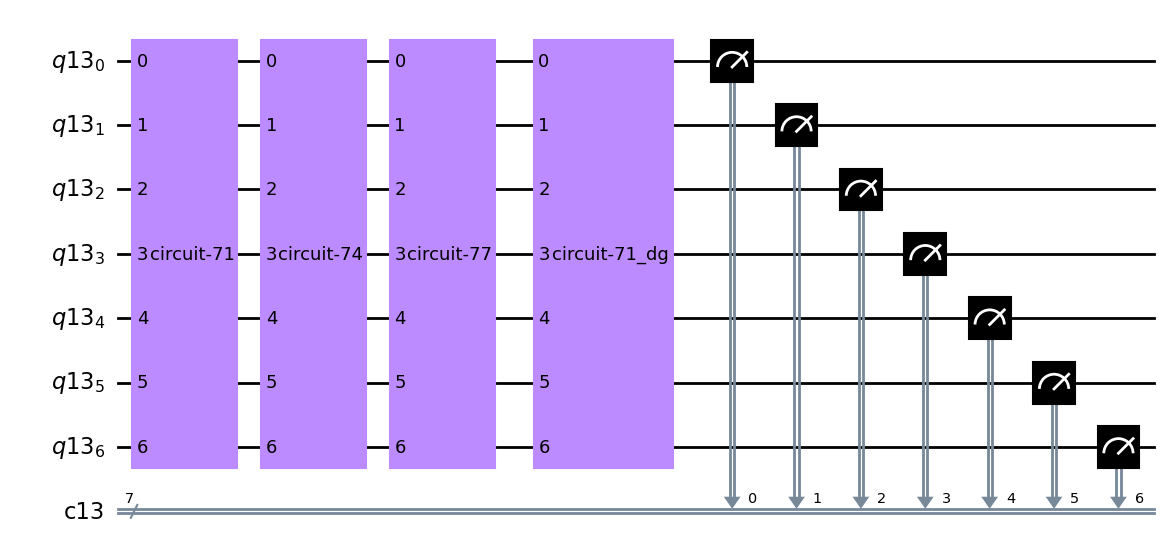

In [19]:
qr = QuantumRegister(7)
cr = ClassicalRegister(7)
qc = QuantumCircuit(qr,cr)


qft_gate = custom_qft()

qc.append(qft_gate, qr[:])
qc.append(subroutine_add_const(4),qr[:])
qc.append(subroutine_add_const(2),qr[:])
qc.append(qft_gate.inverse(), qr[:])


qc.measure(qr,cr)
qc.draw(output='mpl')

In [80]:
int(list(counts.keys())[0],2)

1

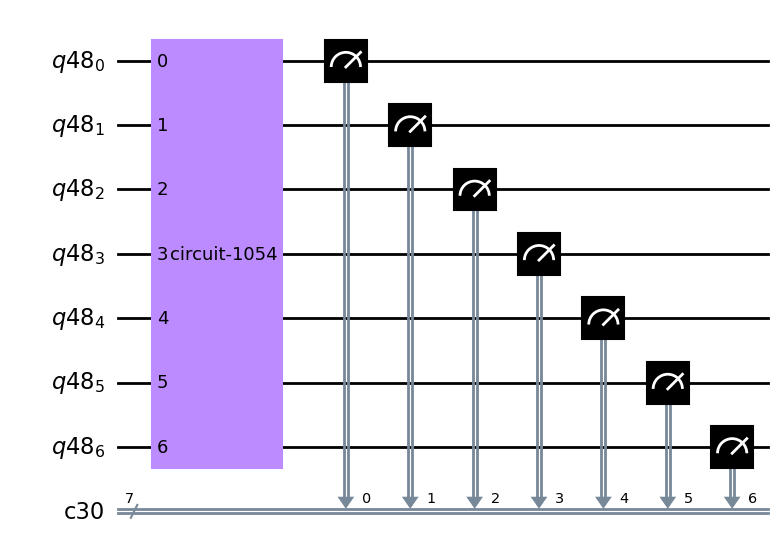

In [24]:
qft_circuits=[]
for i in range(1,8):
    qr = QuantumRegister(7)
    cr = ClassicalRegister(7)
    qc = QuantumCircuit(qr,cr)
    
    qft_gate = custom_qft()
    
    qc.append(qft_gate, qr[:])
    qc.measure(qr,cr)
    qft_circuits.append(qc)
qft_circuits[1].draw(output='mpl')

In [103]:
import qiskit
from qiskit import *
from qiskit.providers.ibmq import *
# from qiskit.transpiler import PassManager
# from qiskit.converters import circuit_to_dag
# from qiskit.transpiler.passes import Unroller
# from qiskit.circuit.random import random_circuit
# from qiskit.transpiler.passes import LookaheadSwap, StochasticSwap
# from qiskit.transpiler import CouplingMap
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends(simulator=False)
backend = provider.get_backend("ibm_nairobi")

ibmqfactory.load_account:WARNING:2023-11-26 17:31:37,489: Credentials are already in use. The existing account in the session will be replaced.


In [104]:
optimization_level = 3
new_circ_lv3 = transpile(qft_circuits[1], backend=backend, optimization_level=optimization_level)
new_circ_lv3_na = transpile(qft_circuits[1], backend=backend, optimization_level=optimization_level,layout_method='noise_adaptive')
new_circ_lv3_sabre = transpile(qft_circuits[1], backend=backend, optimization_level=optimization_level,layout_method='sabre',routing_method='sabre')

In [105]:
coupling_map = IBMQBackend.configuration(backend).to_dict()['coupling_map']
cp = CouplingMap(couplinglist=coupling_map)
depths = []
for qc in [new_circ_lv3_na, new_circ_lv3,new_circ_lv3_sabre]:
    depth = qc.depth()
    pass_manager = PassManager(LookaheadSwap(coupling_map=cp))
    lc_qc = pass_manager.run(qc)
    pass_manager = PassManager(StochasticSwap(coupling_map=cp))
    st_qc = pass_manager.run(qc)
    depths.append(depth + lc_qc.depth())
    depths.append(depth + st_qc.depth())
    #print('depth=', depth, ' depth + routing_lc_qc= ', depth + lc_qc.depth(), ' depth + routing_st_qc=',depth + st_qc.depth())
print("Depth:",depths)
if depths.index(min(depths)) < 2:
    print('na')
    # if show == True:
    #     plot_circuit_layout(new_circ_lv3_na, backend).show()
    print(new_circ_lv3_na._layout.get_physical_bits())
    

if depths.index(min(depths)) >= 2 and depths.index(min(depths)) <4:
    print('not na')
    # if show == True:
    #     plot_circuit_layout(new_circ_lv3, backend).show()
    print(new_circ_lv3._layout.get_physical_bits())
    

else:
    print('SABRE')
    # if show == True:
    #     plot_circuit_layout(new_circ_lv3_sabre, backend).show()
    print(new_circ_lv3_sabre._layout.get_physical_bits())
    

Depth: [20, 20, 20, 20, 20, 20]
na
{4: Qubit(QuantumRegister(7, 'q126690'), 0), 5: Qubit(QuantumRegister(7, 'q126690'), 1), 0: Qubit(QuantumRegister(7, 'q126690'), 2), 1: Qubit(QuantumRegister(7, 'q126690'), 3), 2: Qubit(QuantumRegister(7, 'q126690'), 4), 3: Qubit(QuantumRegister(7, 'q126690'), 5), 6: Qubit(QuantumRegister(7, 'q126690'), 6)}
SABRE
{1: Qubit(QuantumRegister(7, 'q126690'), 0), 3: Qubit(QuantumRegister(7, 'q126690'), 1), 2: Qubit(QuantumRegister(7, 'q126690'), 2), 4: Qubit(QuantumRegister(7, 'q126690'), 3), 0: Qubit(QuantumRegister(7, 'q126690'), 4), 5: Qubit(QuantumRegister(7, 'q126690'), 5), 6: Qubit(QuantumRegister(7, 'q126690'), 6)}


In [42]:
from qiskit.circuit.library import QFT

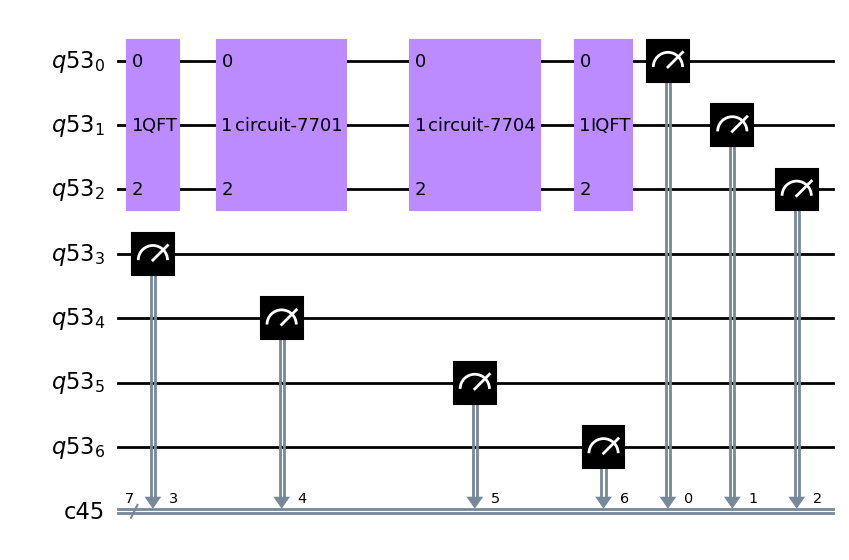

In [60]:
qc = QuantumRegister(7)
cr = ClassicalRegister(7)
qc = QuantumCircuit(qr,cr)
def qft(num_qubits,is_inverse):
    qft_gate = QFT(num_qubits=num_qubits, do_swaps=False, inverse=is_inverse).to_gate()
    return qft_gate

def subroutine_add_const(num_qubits,const):
    qc = QuantumCircuit(num_qubits)

    for i in range(num_qubits):
        angle = const*np.pi/(2**i)
        qc.p(angle,i)

    return qc.to_gate()
qc.append(qft(3,False), qr[:3])
qc.append(subroutine_add_const(3,1), qr[:3])
qc.append(subroutine_add_const(3,1), qr[:3])
qc.append(qft(3,True), qr[:3])
qc.measure(qr,cr)
qc.draw(output='mpl')

In [61]:
from qiskit import BasicAer, execute
backend = BasicAer.get_backend("qasm_simulator")
counts = execute(qc,backend,shots=100).result().get_counts()
counts

{'0000010': 100}